## 1. Setup and Get Data

### 1.1 Install Dependencis and Setup

### 1.2 Collect Images Using OpenCV

In [1]:
import os 
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join("data", "images")
number_images = 30

In [5]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print(f"Collecting Image {imgnum}")
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH, f"{str(uuid.uuid1())}.jpg")
    cv2.imwrite(imgname, frame)
    cv2.imshow("frame", frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [6]:
# !labelme

## 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [4]:
import tensorflow as tf 
import json
import numpy as np
import matplotlib.pyplot as plt

### 2.2 Limit GPU Memory Growth

In [6]:
gpus = tf.config.experimental.list_physical_devices("GPU")
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

In [7]:
tf.config.list_physical_devices("GPU")

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### 2.3 Load Image in TF Data Pipeline

In [8]:
images = tf.data.Dataset.list_files("data\\images\\*.jpg", shuffle = False)

InvalidArgumentError: Expected 'tf.Tensor(False, shape=(), dtype=bool)' to be true. Summarized data: b'No files matched pattern: data\\images\\*.jpg'

In [2]:
def load_image(x):
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [ ]:
images = images.map(load_image)

In [ ]:
images.as_numpy_iterator().next()

array([[[203, 203, 205],
        [212, 212, 212],
        [219, 219, 217],
        ...,
        [252, 255, 255],
        [252, 255, 255],
        [252, 255, 255]],

       [[204, 204, 206],
        [212, 212, 212],
        [218, 219, 214],
        ...,
        [250, 254, 253],
        [250, 254, 253],
        [250, 254, 253]],

       [[204, 204, 204],
        [211, 211, 209],
        [218, 219, 213],
        ...,
        [251, 255, 254],
        [251, 255, 254],
        [251, 255, 254]],

       ...,

       [[145, 147, 136],
        [147, 149, 138],
        [146, 147, 139],
        ...,
        [ 92,  94,  89],
        [110, 112, 107],
        [117, 119, 114]],

       [[143, 144, 138],
        [142, 143, 137],
        [139, 140, 134],
        ...,
        [107, 108, 102],
        [117, 118, 112],
        [122, 123, 117]],

       [[140, 141, 136],
        [138, 139, 134],
        [134, 135, 130],
        ...,
        [114, 115, 109],
        [111, 112, 106],
        [120, 121, 115]]

### 2.4 View Raw Images with Matplotlib

In [ ]:
image_generator = images.batch(4).as_numpy_iterator()

In [ ]:
plot_images = image_generator.next()

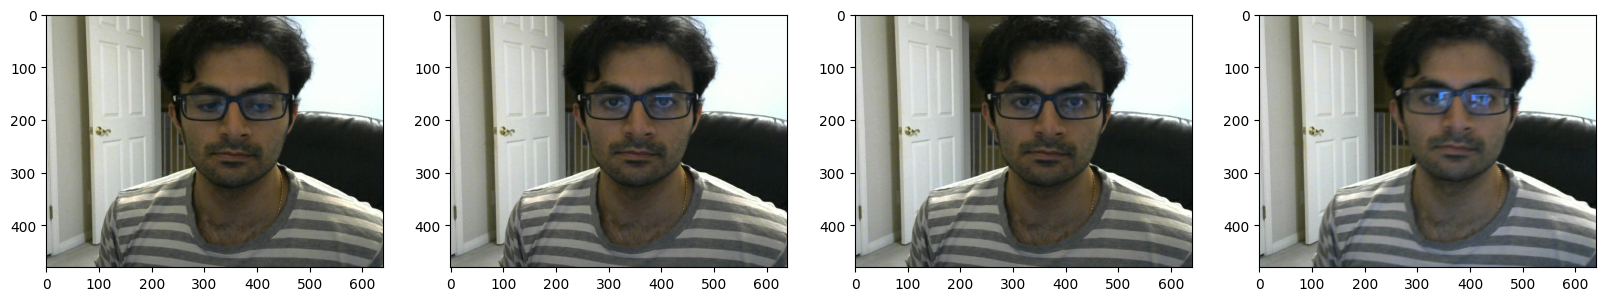

In [ ]:
fig, ax = plt.subplots(ncols=4, figsize = (20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image)
plt.show()

## 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLIT DATA INTO TRAIN TEST AND VAL

### 3.2 Move the Matching Labels

In [9]:
for folder in ["train", "test", "val"]:
    for file in os.listdir(os.path.join("data", folder, "images")):
        filename = file.split(".")[0]+".json"
        existing_filepath = os.path.join("data", "labels", filename)
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join("data", folder, "labels", filename)
            os.replace(existing_filepath, new_filepath)

## 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [10]:
import albumentations as A

In [11]:
augmentor = A.Compose([A.RandomCrop(width = 450, height = 450),
                       A.HorizontalFlip(p = 0.5),
                       A.RandomBrightnessContrast(p = 0.2),
                       A.RandomGamma(p = 0.2),
                       A.RGBShift(p = 0.2),
                       A.VerticalFlip(p = 0.5)],
                       bbox_params=A.BboxParams(format="albumentations", 
                                                label_fields=["class_labels"]))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [12]:
img = cv2.imread("C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\facial_recognition\\data\\train\images\\0a5b4fb5-2c1c-11ee-97ee-00d861aafee1.jpg")

In [13]:
with open(("C:\\Users\\Sriram Kidambi\\OneDrive\\Documents\\Python\\computer_vision_practice\\facial_recognition\\data\\train\labels\\0a5b4fb5-2c1c-11ee-97ee-00d861aafee1.json"), "r") as f:
    label = json.load(f)

In [14]:
label["shapes"][0]["points"]

[[345.0, 0.3960396039604017], [624.2079207920792, 319.2079207920792]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [15]:
coords = [0,0,0,0]
coords[0] = label["shapes"][0]["points"][0][0]
coords[1] = label["shapes"][0]["points"][0][1]
coords[2] = label["shapes"][0]["points"][1][0]
coords[3] = label["shapes"][0]["points"][1][1]

In [16]:
coords

[345.0, 0.3960396039604017, 624.2079207920792, 319.2079207920792]

In [17]:
coords = list(np.divide(coords, [640,480,640,480]))

In [18]:
coords

[0.5390625, 0.0008250825082508369, 0.9753248762376238, 0.665016501650165]

### 3.3 Apply Augmentations and View Results

In [19]:
augmented = augmentor(image = img, bboxes = [coords], class_labels = ["face"])

In [23]:
augmented

{'image': array([[[117, 120, 118],
         [117, 121, 116],
         [119, 120, 116],
         ...,
         [102, 116, 114],
         [100, 114, 112],
         [ 96, 115, 112]],
 
        [[118, 119, 117],
         [114, 118, 113],
         [116, 117, 113],
         ...,
         [ 97, 111, 109],
         [ 94, 108, 106],
         [ 95, 114, 111]],
 
        [[113, 111, 110],
         [111, 112, 108],
         [113, 112, 108],
         ...,
         [ 96, 110, 109],
         [ 95, 109, 108],
         [ 98, 114, 113]],
 
        ...,
 
        [[255,   0,   0],
         [255,   0,   0],
         [104, 103,  99],
         ...,
         [157, 178, 176],
         [141, 163, 161],
         [133, 157, 157]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [158, 179, 177],
         [142, 164, 162],
         [133, 157, 157]],
 
        [[255,   0,   0],
         [255,   0,   0],
         [255,   0,   0],
         ...,
         [157, 179,

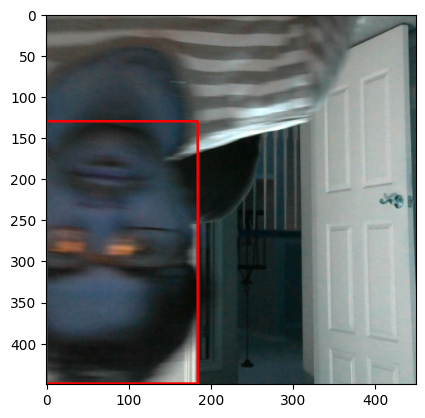

In [21]:
cv2.rectangle(augmented["image"],
              tuple(np.multiply(augmented["bboxes"][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented["bboxes"][0][2:], [450, 450]).astype(int)),
              (255,0,0),2)
plt.imshow(augmented["image"])

## 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [24]:
for partition in ["train", "test", "val"]:
    for image in os.listdir(os.path.join("data", partition, "images")):
        img = cv2.imread(os.path.join("data", partition, "images", image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join("data", partition, "labels", f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, "r") as f:
                label = json.load(f)
            
            coords[0] = label["shapes"][0]["points"][0][0]
            coords[1] = label["shapes"][0]["points"][0][1]
            coords[2] = label["shapes"][0]["points"][1][0]
            coords[3] = label["shapes"][0]["points"][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))
        
        try:
            for x in range(60):
                augmented = augmentor(image = img, bboxes = [coords], class_labels = ["face"])
                cv2.imwrite(os.path.join("aug_data", partition, "images", f'{image.split(".")[0]}.{x}.jpg'), augmented["image"])

                annotation = {}
                annotation["image"] = image

                if os.path.exists(label_path):
                    if len(augmented["bboxes"]) == 0:
                        annotation["bbox"] = [0,0,0,0]
                        annotation["class"] = 0
                    else:
                        annotation["bbox"] = augmented["bboxes"][0]
                        annotation["class"] = 1
                else:
                    annotation["bbox"] = [0,0,0,0]
                    annotation["class"] = 0

                with open(os.path.join("aug_data", partition, "labels", f'{image.split(".")[0]}.{x}.json'), "w") as f:
                    json.dump(annotation, f)
        
        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [5]:
train_images = tf.data.Dataset.list_files("aug_data\\train\\images\\*.jpg", shuffle = False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [6]:
test_images = tf.data.Dataset.list_files("aug_data\\test\\images\\*.jpg", shuffle = False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [7]:
val_images = tf.data.Dataset.list_files("aug_data\\val\\images\\*.jpg", shuffle = False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

## 6. Prepare Labels

### 6.1 Build Label Loading Function

In [8]:
def load_labels(label_path):
    with open(label_path.numpy(), "r", encoding = "utf-8") as f:
        label = json.load(f)
    
    return [label["class"], label["bbox"]]

### 6.2 Load Labels to Tensorflow Dataset

In [9]:
train_labels = tf.data.Dataset.list_files("aug_data\\train\\labels\\*.json", shuffle = False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [10]:
test_labels = tf.data.Dataset.list_files("aug_data\\test\\labels\\*.json", shuffle = False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [11]:
val_labels = tf.data.Dataset.list_files("aug_data\\val\\labels\\*.json", shuffle = False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

## 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [12]:
len(train_images), len(train_labels), len(val_images), len(val_labels), len(test_images), len(test_labels)

(3780, 3780, 780, 780, 840, 840)

### 7.2 Create Final Datasets (Images/Labels)

In [13]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [14]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [15]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

### 7.3 View Images and Annotations

In [16]:
data_samples = train.as_numpy_iterator()

In [17]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


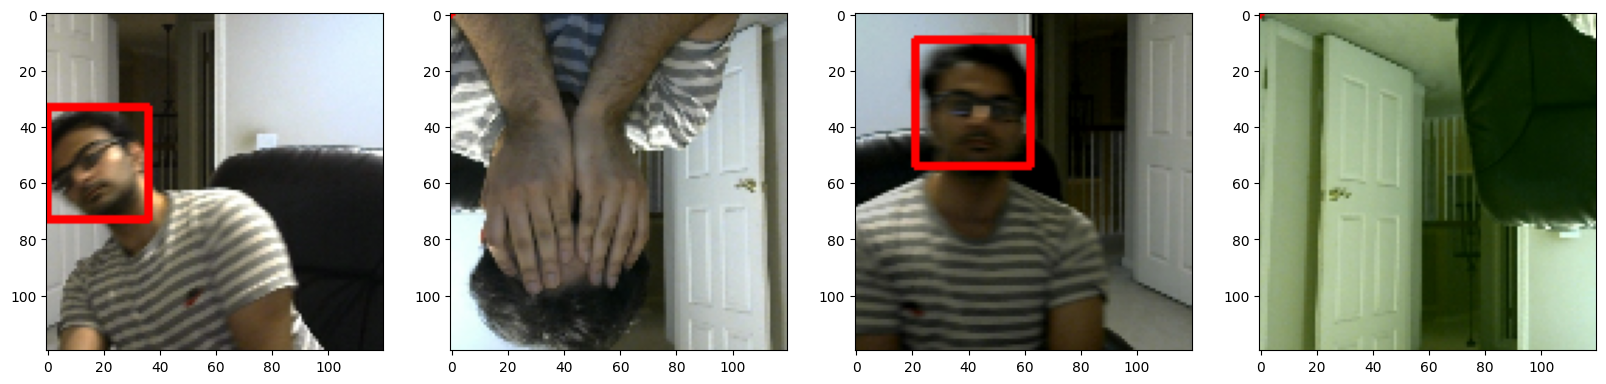

In [18]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image,
              tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
              tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
              (255,0,0),2)
    
    ax[idx].imshow(sample_image)   

## 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [23]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [24]:
vgg = VGG16(include_top=False)

58889256/58889256 [==============================] - 5s 0us/step


In [25]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.2 Build Instance of Network

In [37]:
train.as_numpy_iterator().next()[1][1].shape

(8, 4)

In [44]:
def build_model():
    input_layer = Input(shape=(120,120,3))

    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation = "relu", name = "classification_layer_1")(f1)
    class2 = Dense(1, activation = "sigmoid", name = "classification_layer_2")(class1)

    # Regression Model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation = "relu", name = "regression_layer_1")(f2)
    regress2 = Dense(4, activation = "sigmoid", name = "regression_layer_2")(regress1)

    facetracker = Model(inputs=input_layer, outputs = [class2, regress2])

    return facetracker

### 8.4 Test out Neural Network

In [45]:
facetracker = build_model()

In [46]:
facetracker.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_6[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d_3 (Global  (None, 512)         0           ['vgg16[0][0]']                  
 MaxPooling2D)                                                                              

In [47]:
X, y = train.as_numpy_iterator().next()

In [55]:
y

(array([0, 0, 0, 1, 0, 1, 1, 1], dtype=uint8),
 array([[0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.     , 0.3503 , 0.4646 , 0.9907 ],
        [0.     , 0.     , 0.     , 0.     ],
        [0.307  , 0.3447 , 0.8613 , 1.     ],
        [0.     , 0.289  , 0.1927 , 0.6235 ],
        [0.     , 0.05807, 0.1917 , 0.6104 ]], dtype=float16))

In [65]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 0s 16ms/step


In [66]:
classes, coords

(array([[0.45876125],
        [0.4774059 ],
        [0.4483842 ],
        [0.4744661 ],
        [0.48011926],
        [0.4667535 ],
        [0.45304778],
        [0.40120894]], dtype=float32),
 array([[0.43240926, 0.2837428 , 0.56756943, 0.3231583 ],
        [0.5933964 , 0.37871635, 0.6331812 , 0.43473056],
        [0.4868425 , 0.37330267, 0.67826754, 0.38113648],
        [0.42798138, 0.29856881, 0.67558634, 0.30904493],
        [0.39181373, 0.21609826, 0.6266141 , 0.36048508],
        [0.43484905, 0.31144276, 0.66513765, 0.31818816],
        [0.38008076, 0.2521342 , 0.614329  , 0.3010299 ],
        [0.49550277, 0.33422205, 0.6861023 , 0.37913305]], dtype=float32))

## 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [68]:
batches_per_epoch = len(train)
lr_decay = (1/0.75 - 1)/batches_per_epoch

In [69]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001, decay = lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [70]:
def localization_loss(y_true, y_hat):
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - y_hat[:,:2]))

    h_true = y_true[:,3] - y_true[:,1]
    w_true = y_true[:,2] - y_true[:,0]

    h_pred = y_hat[:,3] - y_hat[:,1]
    w_pred = y_hat[:,2] - y_hat[:,0]

    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true - h_pred))

    return delta_coord + delta_size 

In [71]:
class_loss = tf.keras.losses.BinaryCrossentropy()
regress_loss = localization_loss

### 9.3 Test out Loss Metrics

In [76]:
localization_loss(y[1], coords).numpy()

3.4584465

In [77]:
class_loss(y[0], classes).numpy()

0.6979524

## 10. Train Neural Network

### 10.1 Create Custom Model Class

In [78]:
class FaceTracker(Model):
    def __init__(self, facetracker, **kwargs):
        super().__init__(**kwargs)
        self.model = facetracker
    
    def compile(self, opt, class_loss, localization_loss, **kwargs):
        super().compile(**kwargs)
        self.closs = class_loss
        self.lloss = localization_loss
        self.opt = opt

    def train_step(self, batch, **kwargs):
        X, y = batch

        with tf.GradientTape() as tape:
            classes, coords = self.model(X, training = True)

            batch_class_loss = self.closs(y[0], classes)
            batch_localization_loss = self.lloss(tf.cast(y[1], tf.float32), coords)

            total_loss = batch_localization_loss+0.5*batch_class_loss

            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))

        return {"total_loss":total_loss,
                "class_loss":batch_class_loss,
                "regress_loss":batch_localization_loss}

    def test_step(self, batch, **kwargs):
        X, y = batch

        classes, coords = self.model(X, training = False)

        batch_class_loss = self.closs(y[0], classes)
        batch_localization_loss = self.lloss(tf.cast(y[1], tf.float32), coords)

        total_loss = batch_localization_loss+0.5*batch_class_loss

        return {"total_loss":total_loss,
                "class_loss":batch_class_loss,
                "regress_loss":batch_localization_loss}
    
    def call(self, X, **kwargs):
        return self.model(X, **kwargs)

In [81]:
model = FaceTracker(facetracker)

In [83]:
model.compile(opt, class_loss, regress_loss)

### 10.2 Train

In [84]:
logdir = "logs"

In [85]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [86]:
hist = model.fit(train, epochs = 40, validation_data = val, callbacks = [tensorboard_callback])

Epoch 1/40
473/473 [==============================] - 45s 82ms/step - total_loss: 0.3975 - class_loss: 0.1096 - regress_loss: 0.3427 - val_total_loss: 0.1210 - val_class_loss: 0.0252 - val_regress_loss: 0.1084
Epoch 2/40
473/473 [==============================] - 38s 74ms/step - total_loss: 0.1162 - class_loss: 0.0374 - regress_loss: 0.0974 - val_total_loss: 0.0254 - val_class_loss: 0.0015 - val_regress_loss: 0.0246
Epoch 3/40
473/473 [==============================] - 38s 74ms/step - total_loss: 0.0902 - class_loss: 0.0323 - regress_loss: 0.0741 - val_total_loss: 0.0338 - val_class_loss: 0.0011 - val_regress_loss: 0.0333
Epoch 4/40
473/473 [==============================] - 39s 77ms/step - total_loss: 0.0667 - class_loss: 0.0236 - regress_loss: 0.0549 - val_total_loss: 0.0063 - val_class_loss: 0.0044 - val_regress_loss: 0.0041
Epoch 5/40
473/473 [==============================] - 36s 71ms/step - total_loss: 0.0550 - class_loss: 0.0180 - regress_loss: 0.0460 - val_total_loss: 0.0012 - 

### 10.3 Plot Performance

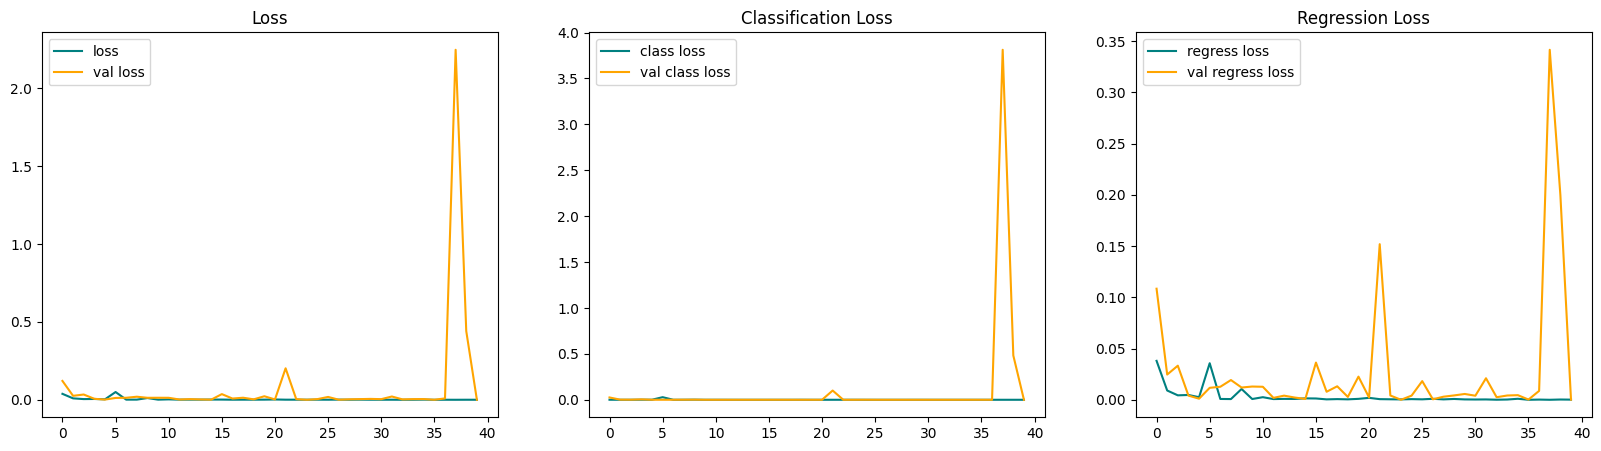

In [90]:
fig, ax = plt.subplots(ncols = 3, figsize = (20,5))

ax[0].plot(hist.history["total_loss"], color = "teal", label = "loss")
ax[0].plot(hist.history["val_total_loss"], color = "orange", label = "val loss")
ax[0].set_title("Loss")
ax[0].legend()

ax[1].plot(hist.history["class_loss"], color = "teal", label = "class loss")
ax[1].plot(hist.history["val_class_loss"], color = "orange", label = "val class loss")
ax[1].set_title("Classification Loss")
ax[1].legend()

ax[2].plot(hist.history["regress_loss"], color = "teal", label = "regress loss")
ax[2].plot(hist.history["val_regress_loss"], color = "orange", label = "val regress loss")
ax[2].set_title("Regression Loss")
ax[2].legend()

plt.show()

## 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [91]:
test_data = test.as_numpy_iterator()

In [98]:
test_sample = test_data.next()

In [99]:
y_hat = facetracker.predict(test_sample[0])

1/1 [==============================] - 0s 17ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


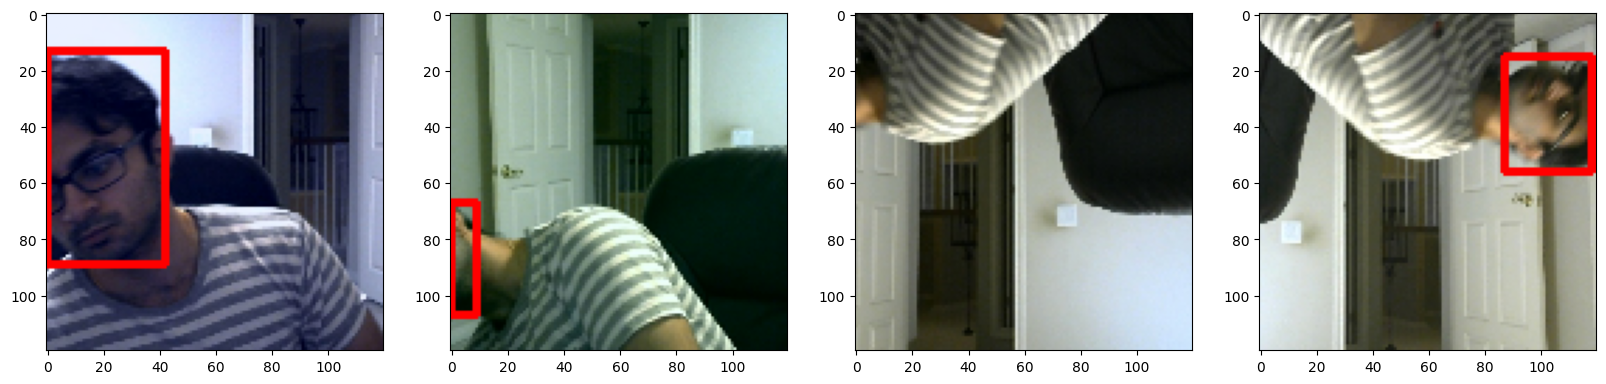

In [100]:
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))
for idx in range(4):
    sample_image = test_sample[0][idx]
    sample_coords = y_hat[1][idx]
    
    if y_hat[0][idx] > 0.5:
        cv2.rectangle(sample_image,
                tuple(np.multiply(sample_coords[:2], [120, 120]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [120, 120]).astype(int)),
                (255,0,0),2)
    
    ax[idx].imshow(sample_image)   

### 11.2 Save the Model

In [101]:
from tensorflow.keras.models import load_model

In [112]:
facetracker.save('facetracker',save_format='tf')

INFO:tensorflow:Assets written to: facetracker\assets


INFO:tensorflow:Assets written to: facetracker\assets


In [113]:
facetracker = load_model("facetracker")

### 11.3 Real Time Detection

In [118]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _, frame = cap.read()
    frame = frame[50:500, 50:500, :]

    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))

    y_hat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = y_hat[1][0]

    if y_hat[0] > 0.5:
        # Controls the main rectangle
        cv2.rectangle(frame,
                tuple(np.multiply(sample_coords[:2], [450, 450]).astype(int)),
                tuple(np.multiply(sample_coords[2:], [450, 450]).astype(int)),
                (255,0,0),2)
        
        # Controls the label rectangle
        cv2.rectangle(frame,
                      tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [0,-30])),
                        tuple(np.add(np.multiply(sample_coords[:2], [450, 450]).astype(int),
                                    [80,0])),
                            (255,0,0), -1)

        # Controls the text rendered
        cv2.putText(frame, "Sriram", tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                                  [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow("Eyetrack", frame)

    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 14ms/step
